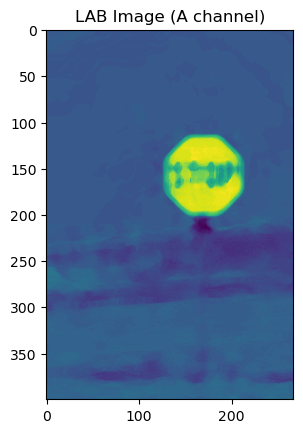

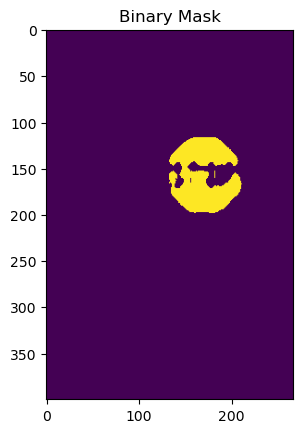

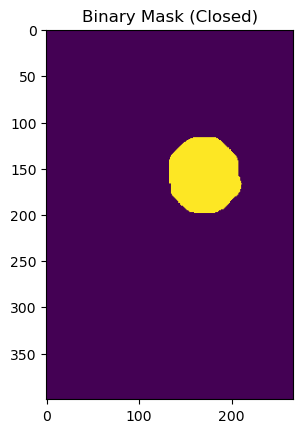

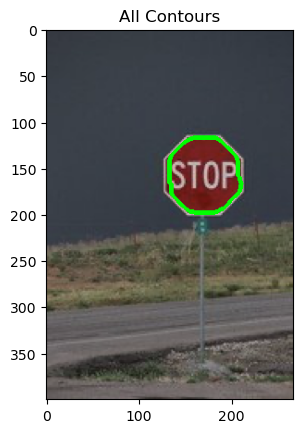

Sign found in this image.


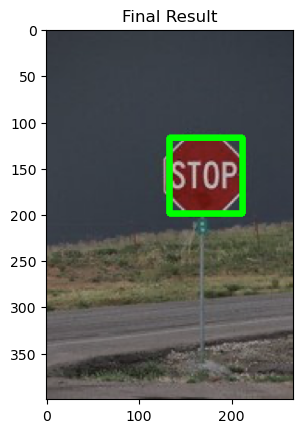

In [13]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

# img stronze v2: 16, 23
dir_path = './images/'
i = 2
img_name = f'stop{i}.png'
img_path = os.path.join(dir_path, img_name)
img = cv2.imread(img_path)

# apply median filter to remove noise
img_medianfiltered = cv2.medianBlur(img, ksize=13)

# convert to LAB image 
img_lab = cv2.cvtColor(img_medianfiltered, cv2.COLOR_BGR2LAB)

# select only the A channel (green-red channel)
a_channel = img_lab[:, :, 1]

# plot only the A channel
plt.imshow(a_channel)
plt.title("LAB Image (A channel)")
plt.show()

# flatten the image to perform k-means clustering
flat_img = a_channel.reshape((-1, 1))
# convert to float32, required by k-means
flat_img = np.float32(flat_img)

# criteria for k-means clustering
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 5

# perform k-means clustering
ret,label,center=cv2.kmeans(
    flat_img,
    K,
    None,
    criteria,
    10,
    cv2.KMEANS_PP_CENTERS
)

# convert the centers to uint8
center = np.uint8(center)

# select the cluster with the maximum a* value (red color)
cluster_id = np.argmax(center)

# create a binary mask for the red cluster
mask_flat = np.where(label.flatten() == cluster_id, 255, 0).astype(np.uint8)

# reshape the mask to the original image dimensions
mask = mask_flat.reshape((img_lab.shape[0], img_lab.shape[1]))

# show the binary mask
plt.imshow(mask)
plt.title("Binary Mask")
plt.show()

# apply morphological operations
kernel = np.ones((31, 31), np.uint8)   
# apply "Closing" to fill holes and merge fragments
mask_curata = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# show the binary mask
plt.imshow(mask_curata)
plt.title("Binary Mask (Closed)")
plt.show()

# find contours
contours, hierarchy = cv2.findContours(mask_curata, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# convert to RGB image
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_contours = img_rgb.copy()
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 3)

plt.imshow(img_contours)
plt.title("All Contours")
plt.show()

img_boxes = img_rgb.copy()

contorno_migliore = None
area_massima_valida = 0

for cnt in contours:
    area = cv2.contourArea(cnt)
    
    if area > 200: 
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = float(w) / h
        
        # find the convex hull and calculate the solidity
        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        
        # avoid division by zero
        if hull_area > 0:
            solidity = float(area) / hull_area
            
            # the signle sign must be a square and solid
            if 0.7 <= aspect_ratio <= 1.3 and solidity > 0.7:
                
                if area > area_massima_valida:
                    area_massima_valida = area
                    contorno_migliore = cnt

# draw the best contour
if contorno_migliore is not None:
    x, y, w, h = cv2.boundingRect(contorno_migliore)
    cv2.rectangle(img_boxes, (x, y), (x+w, y+h), (0, 255, 0), 5)
    print("Sign found in this image.")
else:
    print("No sign found in this image.")

plt.imshow(img_boxes)
plt.title("Final Result")
plt.show()

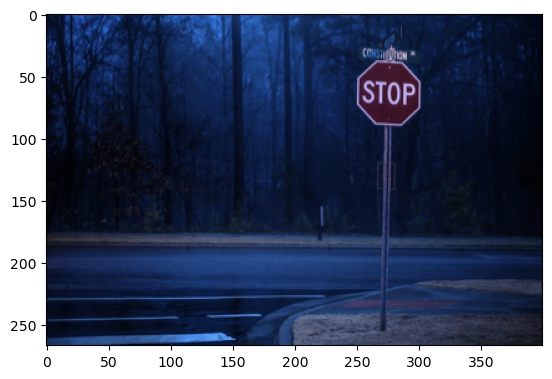

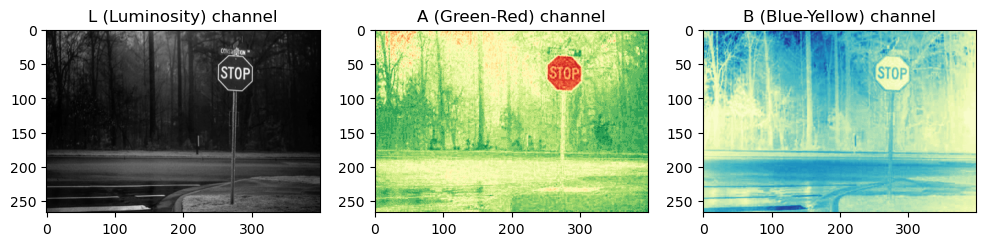

In [5]:
def show_images(img1, img2):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img1)
    plt.subplot(1, 2, 2)
    plt.title('Median Filtered Image')
    plt.imshow(img2)
    plt.show()


def show_images(img1, img2):  
    plt.imshow(img1) # crazy colors
    plt.show()
    # split LAB image into luminosity, green-red, blue-yellow channels
    L, A, B = cv2.split(img2)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title('L (Luminosity) channel')
    plt.imshow(L, cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('A (Green-Red) channel')
    plt.imshow(A, cmap='RdYlGn_r') 

    plt.subplot(1, 3, 3)
    plt.title('B (Blue-Yellow) channel')
    plt.imshow(B, cmap='YlGnBu_r') 

    plt.show()

dir_path = './images/'
i = 18
img_name = f'stop{i}.png'
img_path = os.path.join(dir_path, img_name)
img = cv2.imread(img_path)

# convert and show RGB image
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)

show_images(img_rgb, img_lab)